In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append('C:\\Users\\Graúna Motos\\Documents\\credit_risk')

from src.utils_modelling import analisy_univariate, wo_discretize, plot_woe, wo_discretize_continuos


In [140]:
df = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\bronze\\loan_data_2007_2014 (1).csv')

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\102279003.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\bronze\\loan_data_2007_2014 (1).csv')


In [141]:
def clean(value):
    if pd.isna(value):
        return 0
    elif '10+' in value:
        return 10
    elif '<' in value:
        return 0
    else:
        return float(value.split()[0])
    
df['emp_length_int'] = df['emp_length'].apply(clean)

In [142]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [143]:
pd.to_datetime('2017-12-01') - df['earliest_cr_line_date'] 

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [144]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['earliest_cr_line_date']) / np.timedelta64(1, 'm')))

In [145]:
df.loc[:, ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-23536800.0
1770,Sep-68,2068-09-01,-26693280.0
2799,Sep-64,2064-09-01,-24589440.0
3282,Sep-67,2067-09-01,-26166240.0
3359,Feb-65,2065-02-01,-24809760.0
...,...,...,...
464003,Jan-68,2068-01-01,-26341920.0
464260,Jul-66,2066-07-01,-25551360.0
465100,Oct-67,2067-10-01,-26209440.0
465500,Sep-67,2067-09-01,-26166240.0


In [146]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\3793766548.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()
C:\Use

In [147]:
min(df['mths_since_earliest_cr_line'])

3199680.0

In [148]:
def clean_term(value):
    if pd.isna(value):
        return 0
    elif ' 36 months' in value:
        return 36
    elif ' 60 months' in value:
        return 60
    else:
        return float(value.split()[0])

In [149]:
df['term_int'] = df['term'].apply(clean_term)

In [150]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')

In [151]:
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['issue_d_date'])/np.timedelta64(1, 'm')))

In [152]:
threshold = 10
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < threshold]
print("Variáveis categóricas confirmadas:", categorical_columns)


Variáveis categóricas confirmadas: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'application_type']


In [153]:
df_dummies = [
    pd.get_dummies(df['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(df['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(df['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(df['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(df['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(df['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(df['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(df['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),

]

In [154]:
df_dummies = pd.concat(df_dummies, axis=1)

In [155]:
df = pd.concat([df, df_dummies], axis=1)

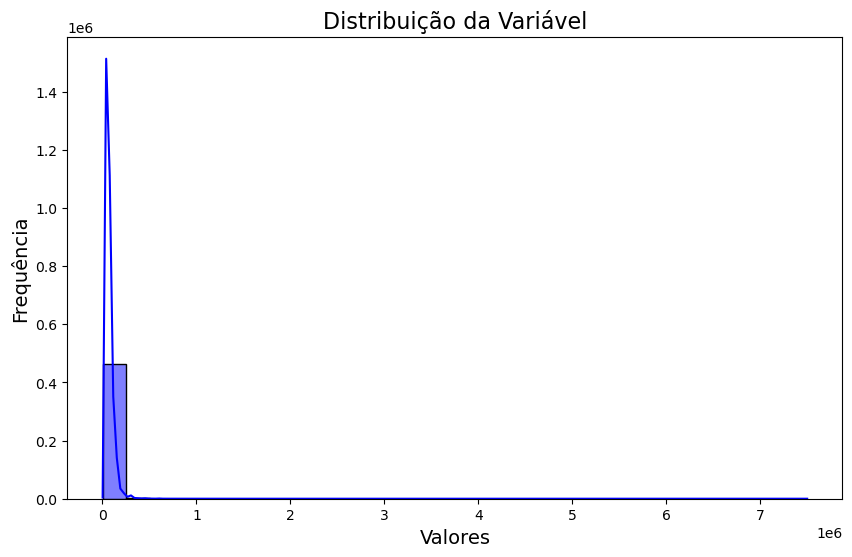

In [156]:
plt.figure(figsize=(10, 6))

# Histograma com KDE (Kernel Density Estimate)
sns.histplot(df['annual_inc'], bins=30, kde=True, color='blue')

# Adicionando título e rótulos
plt.title('Distribuição da Variável', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Exibir o gráfico
plt.show()

In [157]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)


C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\1661146675.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\1661146675.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [158]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)

In [159]:
df['good_bad']
pd.options.display.max_columns = None


In [160]:
df_input_train, df_input_test, df_target_train, df_target_test = train_test_split(df.drop('good_bad', axis = 1), df['good_bad'], test_size=0.2, random_state=42)


In [161]:
df_inputs_prepr = df_input_train
df_target_prepr = df_target_train

In [162]:
df1 = pd.concat([df_inputs_prepr['grade'], df_target_prepr], axis = 1)


In [163]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].count()


,grade,good_bad
0,A,59759
1,B,109730
2,C,100245
3,D,61498
4,E,28612
5,F,10530
6,G,2654


In [164]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].mean()


,grade,good_bad
0,A,0.961044
1,B,0.921015
2,C,0.885770
3,D,0.846304
4,E,0.805257
5,F,0.754416
6,G,0.727958


## Preprocessing Variable Discrete

In [165]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count(),
                 df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()], axis = 1)

In [166]:
df_grade = wo_discretize(df_inputs_prepr, 'grade', df_target_prepr)

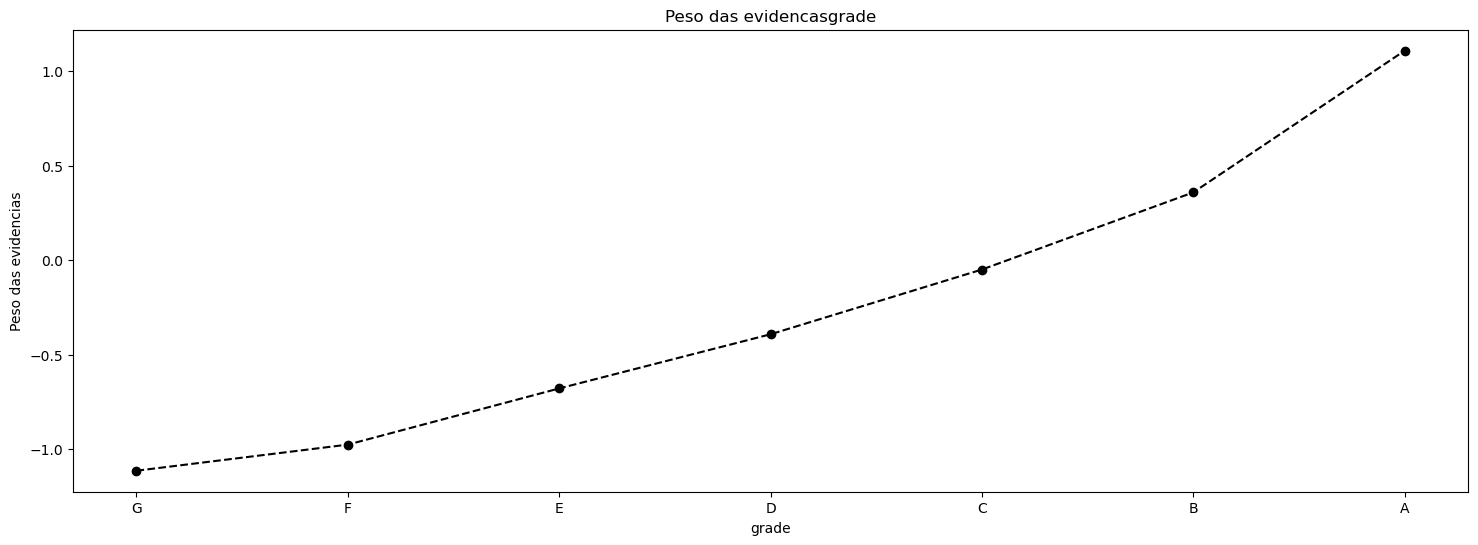

In [167]:
plot_woe(df_grade)

In [168]:
df_home = wo_discretize(df_inputs_prepr, 'home_ownership', df_target_prepr)

In [169]:
df_home

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,NaN,NaN,0.000265,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,0.054380,0.375458,0.000016,inf
2,RENT,150599,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,0.023870,0.201021,0.011303,inf
3,OWN,33295,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,0.018666,0.181294,0.000033,inf
4,MORTGAGE,188956,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,0.011298,0.123663,0.009772,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.096165,inf,inf,inf


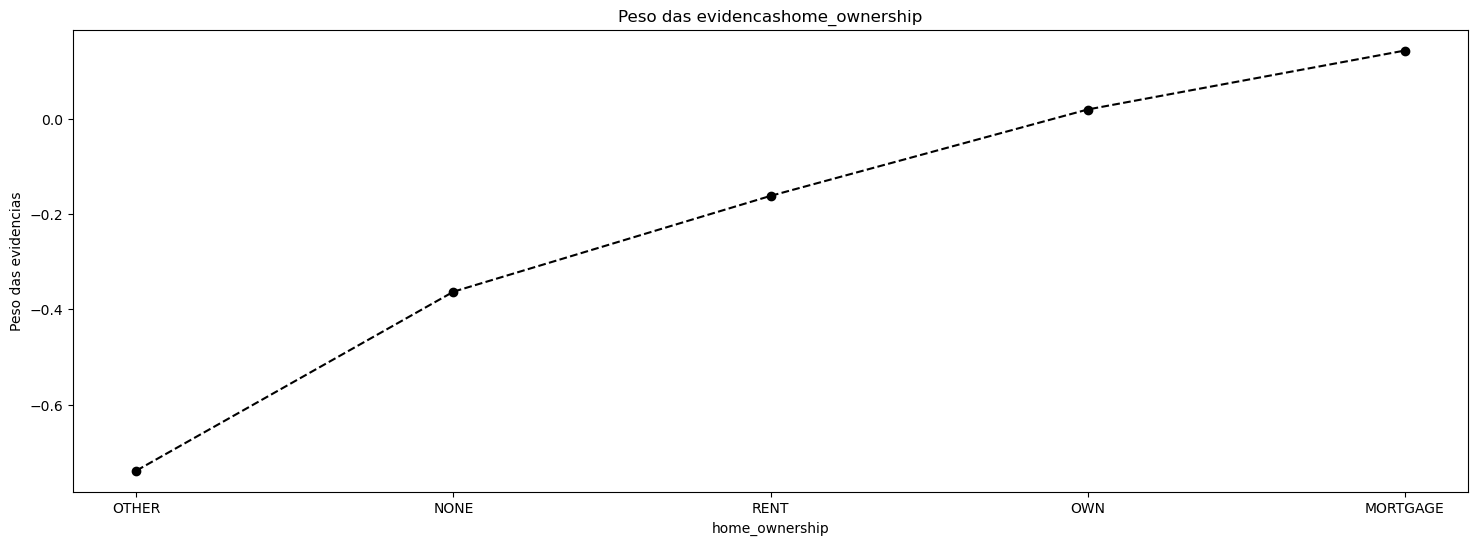

In [170]:
plot_woe(df_home)

In [171]:
df_grade = wo_discretize(df_inputs_prepr, 'purpose', df_target_prepr)

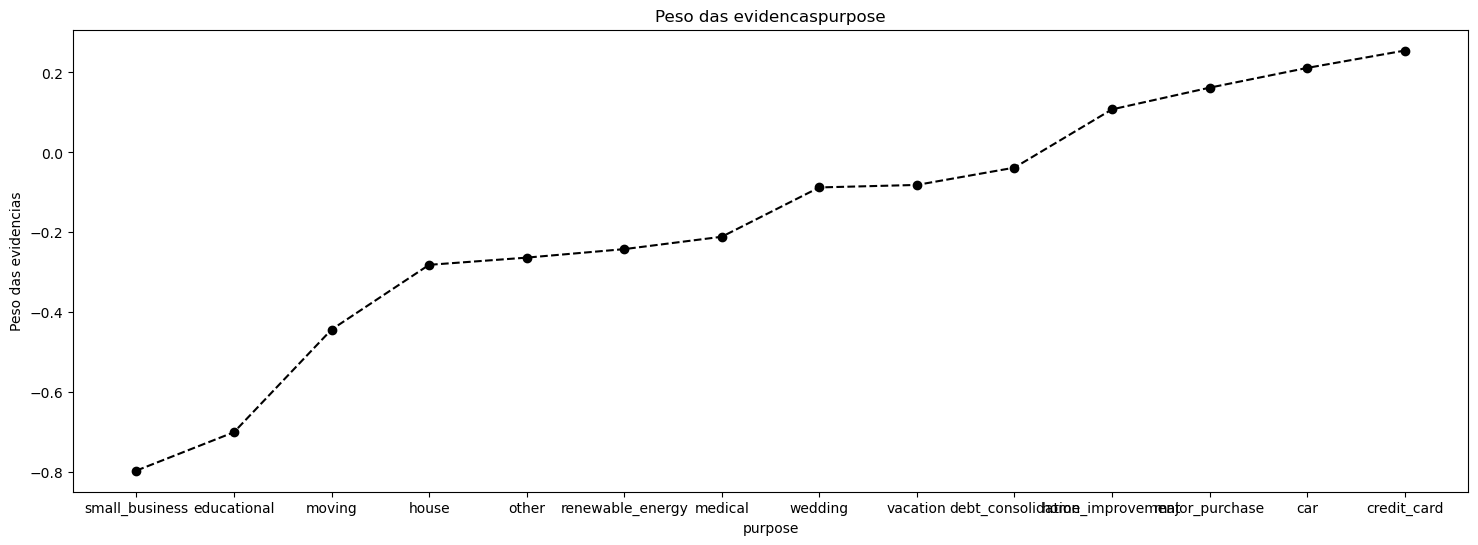

In [172]:
plot_woe(df_grade)

In [173]:
df_status = wo_discretize(df_inputs_prepr, 'verification_status', df_target_prepr)

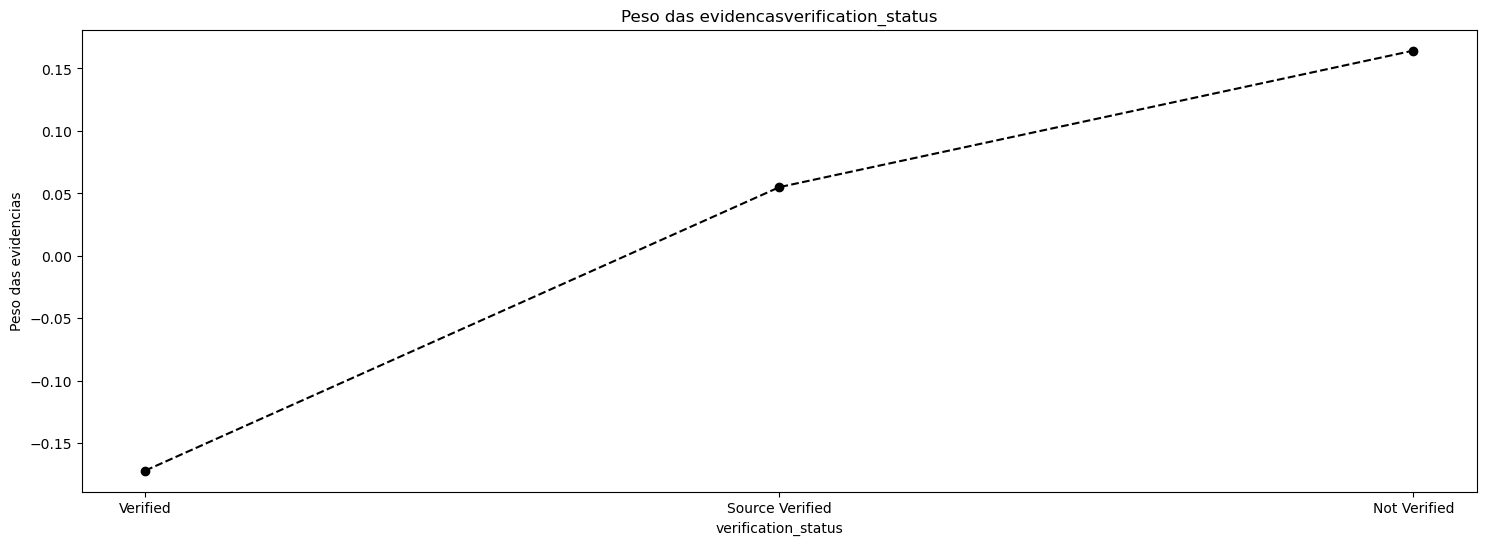

In [174]:
plot_woe(df_status)

In [175]:
df_initial = wo_discretize(df_inputs_prepr, 'initial_list_status', df_target_prepr)

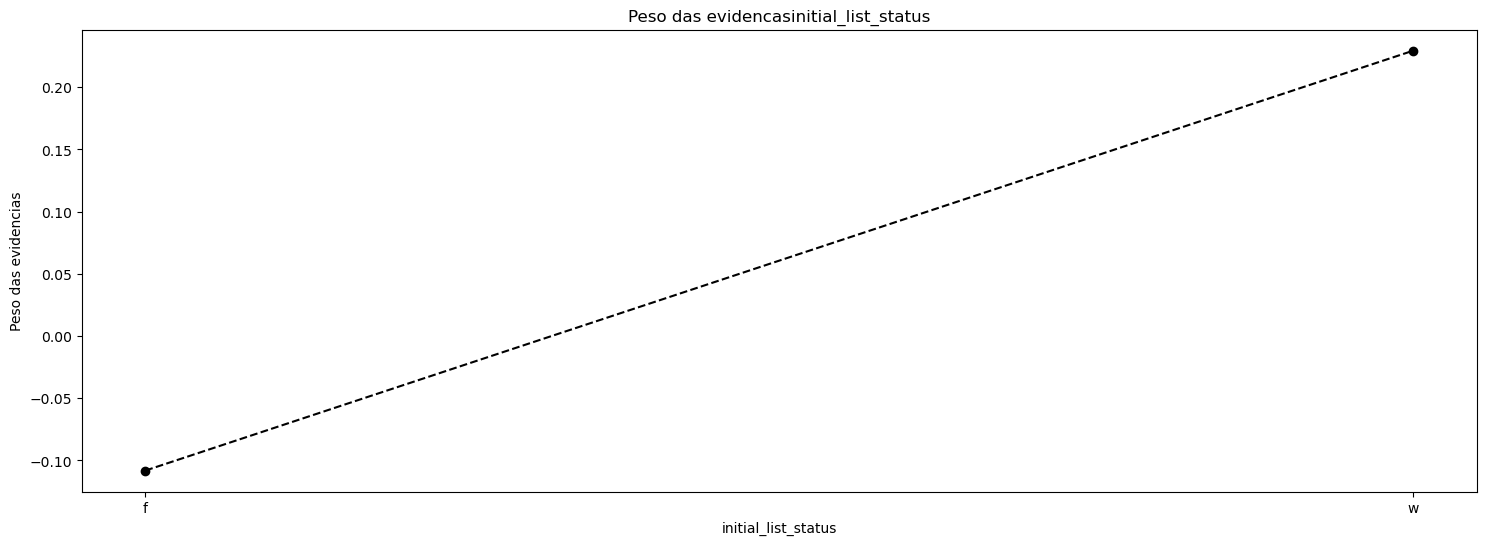

In [176]:
plot_woe(df_initial)

In [177]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [178]:
df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'], df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'], df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'],df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'],df_inputs_prepr['addr_state:TN'], df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'], df_inputs_prepr['addr_state:MD'],
df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'], df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH'] = sum([df_inputs_prepr['addr_state:AR'],df_inputs_prepr['addr_state:MI'], df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'],df_inputs_prepr['addr_state:MA'], df_inputs_prepr['addr_state:DE'],
df_inputs_prepr['addr_state:SD'], df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'], df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'],df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'], df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'], df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])




In [179]:
df_inputs_prepr['purpose:educ_smb_wedd_ren_en_mov_house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'], df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])

df_inputs_prepr['purpose:oth_med_vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'], df_inputs_prepr['purpose:vacation']])

df_inputs_prepr['purpose:major_car_home'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'], df_inputs_prepr['purpose:home_improvement']])

In [180]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],  df_inputs_prepr['home_ownership:NONE'],  df_inputs_prepr['home_ownership:ANY']])

In [181]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE'],df_inputs_prepr['home_ownership:ANY']])

## Preprocessing Variables Continuous

In [182]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'term_int', df_target_prepr)

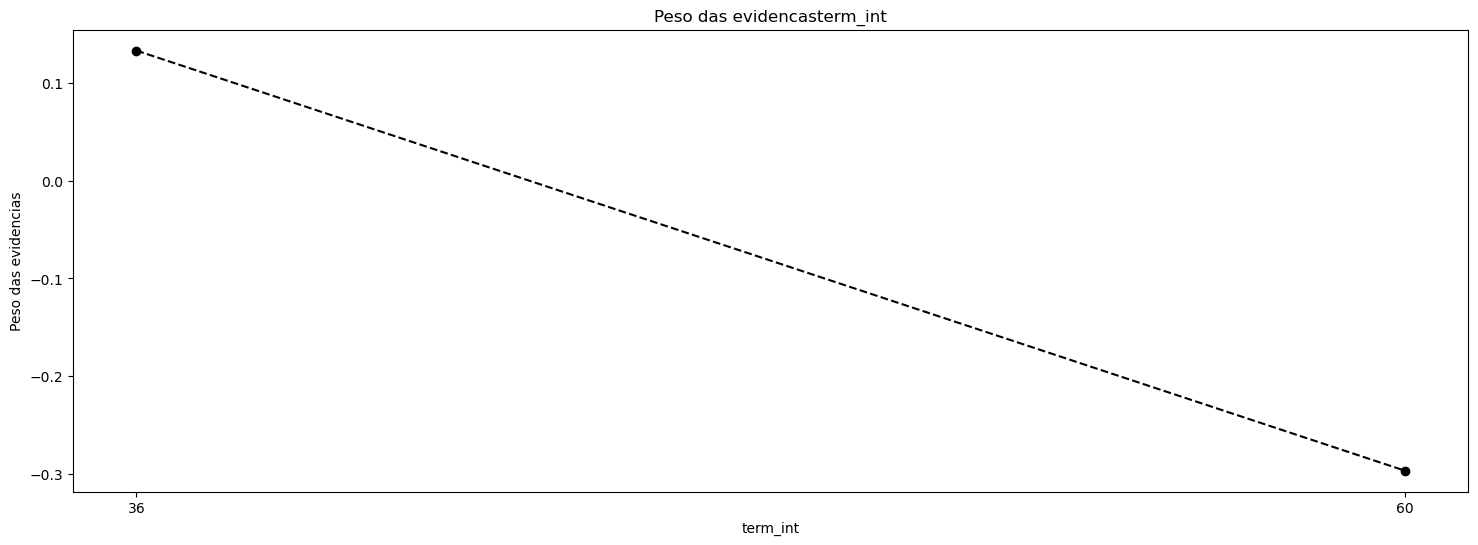

In [183]:
plot_woe(df_temp)

In [184]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int']== 36),1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int']== 60),1, 0)

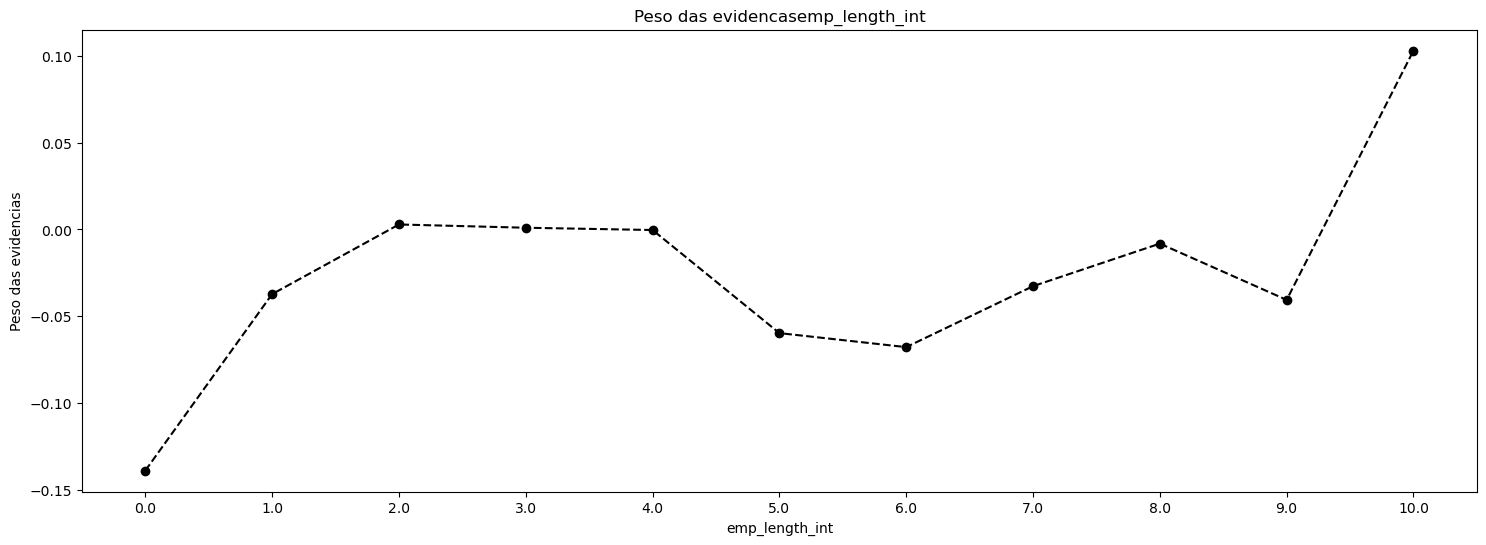

In [185]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'emp_length_int', df_target_prepr)
plot_woe(df_temp)

In [186]:
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]),1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]),1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin([2,5]),1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin([5,7]),1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin([7,10]),1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]),1, 0)


In [187]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)

In [188]:
df_inputs_prepr['mths_since_issue_d_factor']

427211    (1972800.0, 2051712.0]
206088    (2761920.0, 2840832.0]
136020    (2288448.0, 2367360.0]
412305    (1893888.0, 1972800.0]
36159     (4419072.0, 4497984.0]
                   ...          
259178    (1574294.4, 1657152.0]
365838    (1814976.0, 1893888.0]
131932    (2288448.0, 2367360.0]
146867    (2446272.0, 2525184.0]
121958    (2288448.0, 2367360.0]
Name: mths_since_issue_d_factor, Length: 373028, dtype: category
Categories (50, interval[float64, right]): [(1574294.4, 1657152.0] < (1657152.0, 1736064.0] < (1736064.0, 1814976.0] < (1814976.0, 1893888.0] ... (5208192.0, 5287104.0] < (5287104.0, 5366016.0] < (5366016.0, 5444928.0] < (5444928.0, 5523840.0]]

In [189]:
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)),1,0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)),1,0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)),1,0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42,49)),1,0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49,53)),1,0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53,65)),1,0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)


C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


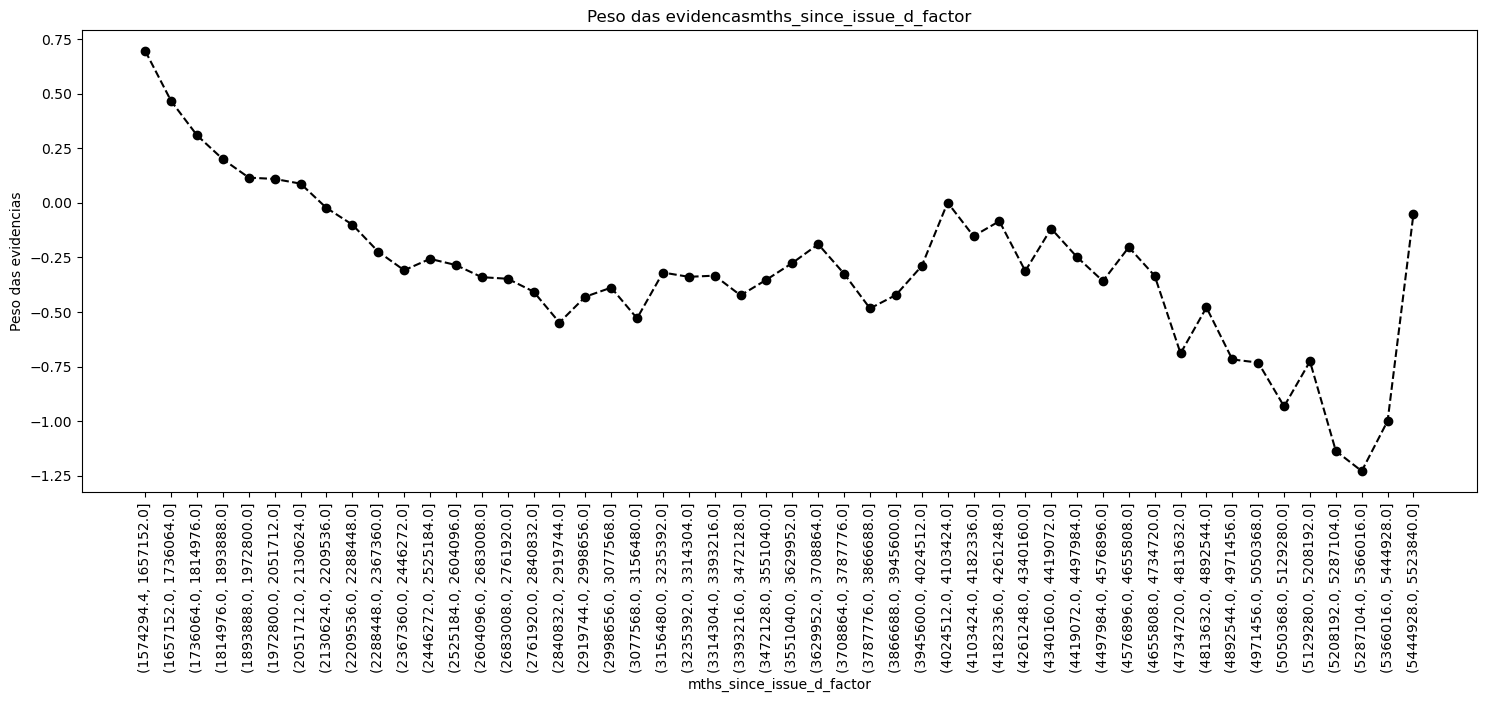

In [190]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'mths_since_issue_d_factor', df_target_prepr)
plot_woe(df_temp, rotation_axis= 90)

In [191]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


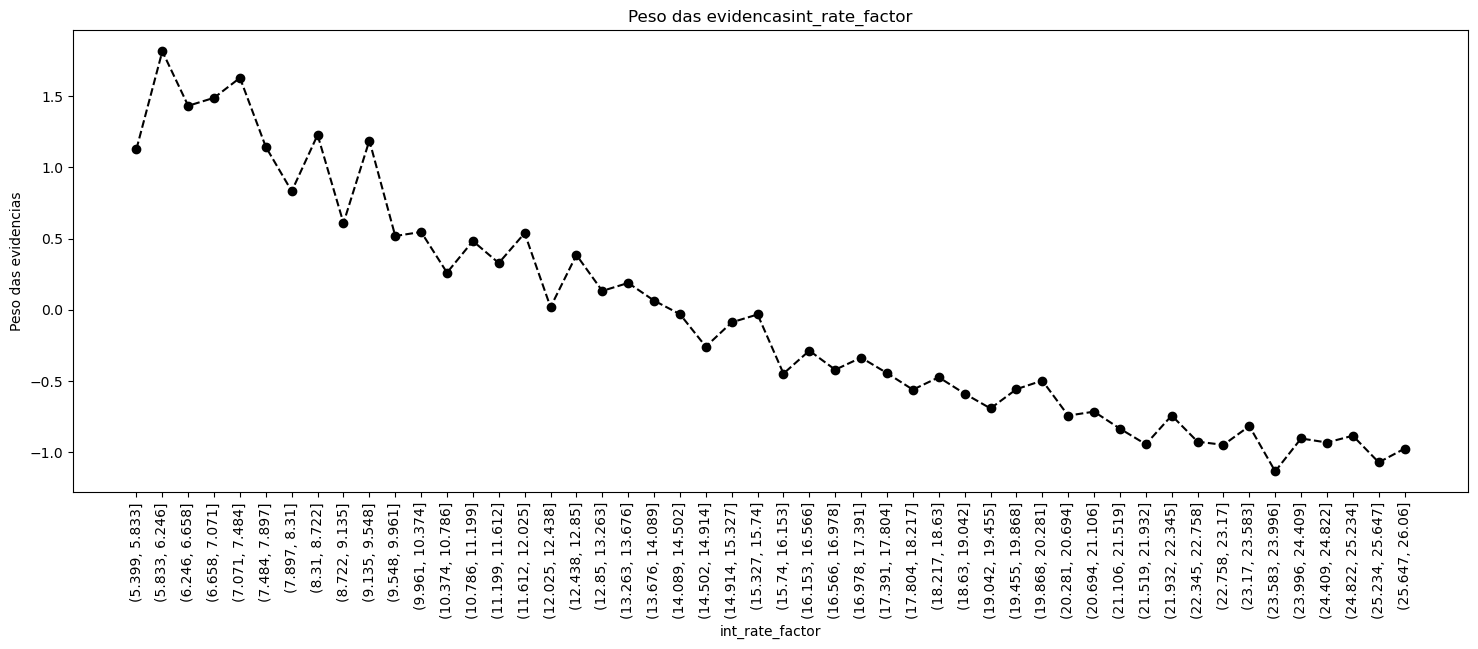

In [192]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'int_rate_factor', df_target_prepr)
plot_woe(df_temp, rotation_axis= 90)

In [193]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)



In [194]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'funded_amnt_factor', df_target_prepr)
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(465.5, 1190.0]",1224,0.905229,0.003281,1108.0,116.0,0.003335,0.002845,0.158977,NaN,NaN,7.792514e-05,0.014139
1,"(1190.0, 1880.0]",3028,0.903897,0.008117,2737.0,291.0,0.008238,0.007136,0.143549,0.001332,0.015427,1.581301e-04,0.014139
2,"(1880.0, 2570.0]",6018,0.893819,0.016133,5379.0,639.0,0.016190,0.015670,0.032608,0.010078,0.110941,1.693683e-05,0.014139
3,"(2570.0, 3260.0]",7248,0.889073,0.019430,6444.0,804.0,0.019395,0.019717,-0.016440,0.004746,0.049048,5.284970e-06,0.014139
4,"(3260.0, 3950.0]",4751,0.891602,0.012736,4236.0,515.0,0.012749,0.012629,0.009463,0.002529,0.025902,1.136265e-06,0.014139
5,"(3950.0, 4640.0]",9023,0.890945,0.024189,8039.0,984.0,0.024196,0.024131,0.002689,0.000656,0.006774,1.747301e-07,0.014139
6,"(4640.0, 5330.0]",15903,0.892159,0.042632,14188.0,1715.0,0.042703,0.042057,0.015238,0.001213,0.012549,9.840896e-06,0.014139
7,"(5330.0, 6020.0]",17236,0.906069,0.046206,15617.0,1619.0,0.047004,0.039703,0.168806,0.013910,0.153568,1.232452e-03,0.014139
8,"(6020.0, 6710.0]",6914,0.887619,0.018535,6137.0,777.0,0.018471,0.019054,-0.031094,0.018449,0.199900,1.813905e-05,0.014139
9,"(6710.0, 7400.0]",11806,0.898018,0.031649,10602.0,1204.0,0.031910,0.029526,0.077648,0.010399,0.108742,1.851122e-04,0.014139


In [195]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_target_prepr)
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-25727.04, 514540.8]",24,0.875000,0.000064,21.0,3.0,0.000063,0.000074,-0.151835,NaN,NaN,1.573565e-06,0.016328
1,"(514540.8, 1029081.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016328
2,"(1029081.6, 1543622.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016328
3,"(1543622.4, 2058163.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016328
4,"(2058163.2, 2572704.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016328
5,"(2572704.0, 3087244.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016328
6,"(3087244.8, 3601785.6]",722,0.898892,0.001936,649.0,73.0,0.001953,0.001790,0.087228,NaN,NaN,1.423281e-05,0.016328
7,"(3601785.6, 4116326.4]",1929,0.884914,0.005171,1707.0,222.0,0.005138,0.005444,-0.057930,0.013978,0.145158,1.775048e-05,0.016328
8,"(4116326.4, 4630867.2]",2817,0.857295,0.007552,2415.0,402.0,0.007269,0.009858,-0.304742,0.027619,0.246813,7.891715e-04,0.016328
9,"(4630867.2, 5145408.0]",5092,0.871170,0.013650,4436.0,656.0,0.013351,0.016087,-0.186397,0.013875,0.118345,5.099300e-04,0.016328


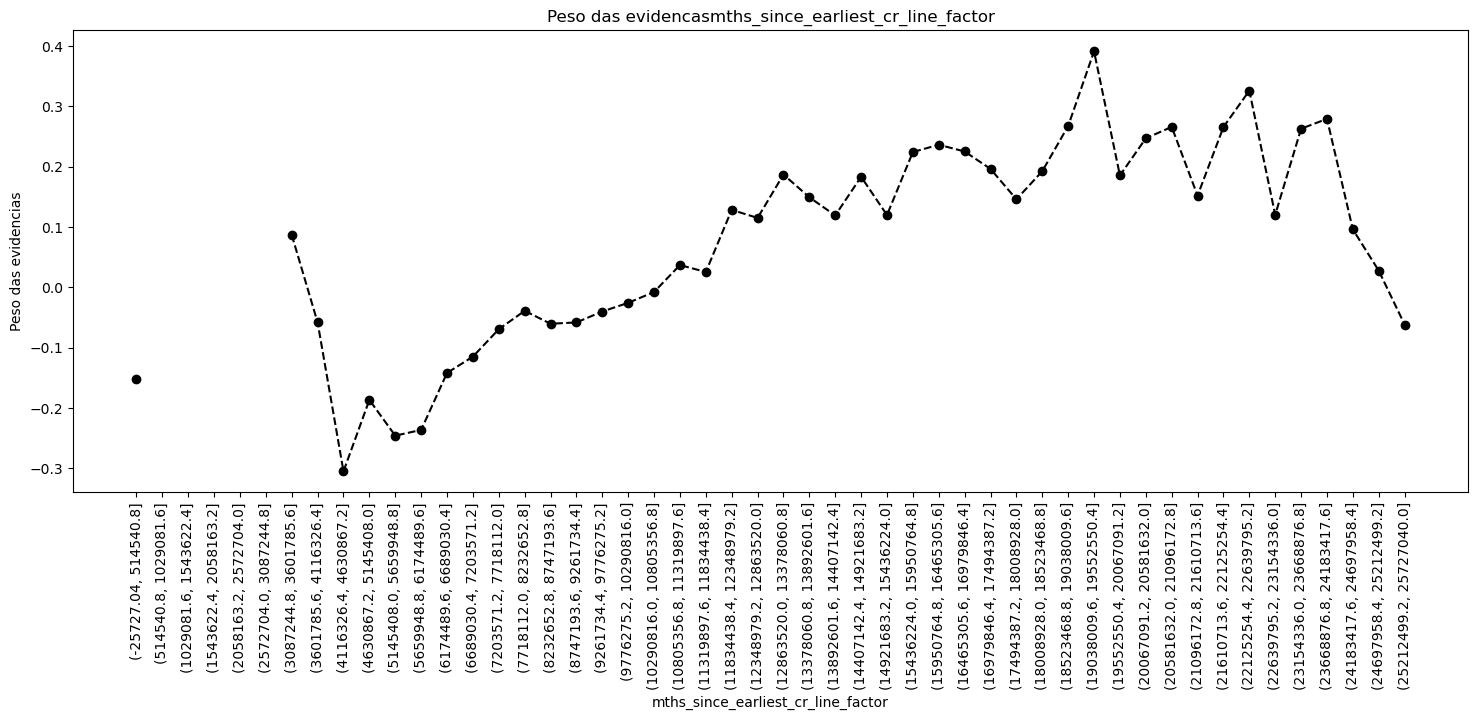

In [196]:
plot_woe(df_temp, 90)


In [197]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [198]:
# delinq_2yrs
df_temp = wo_discretize_continuos(df_inputs_prepr, 'delinq_2yrs', df_target_prepr)
# We calculate weight of evidence.
df_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,306417,0.890499,0.821432,272864.0,33553.0,0.821261,0.822821,-0.001898,NaN,NaN,2.960552e-06,inf
1,1.0,44927,0.893249,0.120439,40131.0,4796.0,0.120786,0.117612,0.026622,0.002750,0.028520,8.447431e-05,inf
2,2.0,13118,0.889007,0.035166,11662.0,1456.0,0.035100,0.035706,-0.017102,0.004242,0.043724,1.035459e-05,inf
3,3.0,4550,0.883297,0.012197,4019.0,531.0,0.012096,0.013022,-0.073719,0.005711,0.056616,6.822026e-05,inf
4,4.0,1868,0.898822,0.005008,1679.0,189.0,0.005053,0.004635,0.086462,0.015526,0.160180,3.619039e-05,inf
5,5.0,966,0.881988,0.002590,852.0,114.0,0.002564,0.002796,-0.086357,0.016835,0.172819,1.997357e-05,inf
6,6.0,501,0.902196,0.001343,452.0,49.0,0.001360,0.001202,0.124117,0.020208,0.210474,1.970890e-05,inf
7,7.0,279,0.860215,0.000748,240.0,39.0,0.000722,0.000956,-0.280668,0.041981,0.404785,6.569040e-05,inf
8,8.0,148,0.905405,0.000397,134.0,14.0,0.000403,0.000343,0.161037,0.045190,0.441705,9.660378e-06,inf
9,9.0,89,0.887640,0.000239,79.0,10.0,0.000238,0.000245,-0.030882,0.017765,0.191920,2.303044e-07,inf


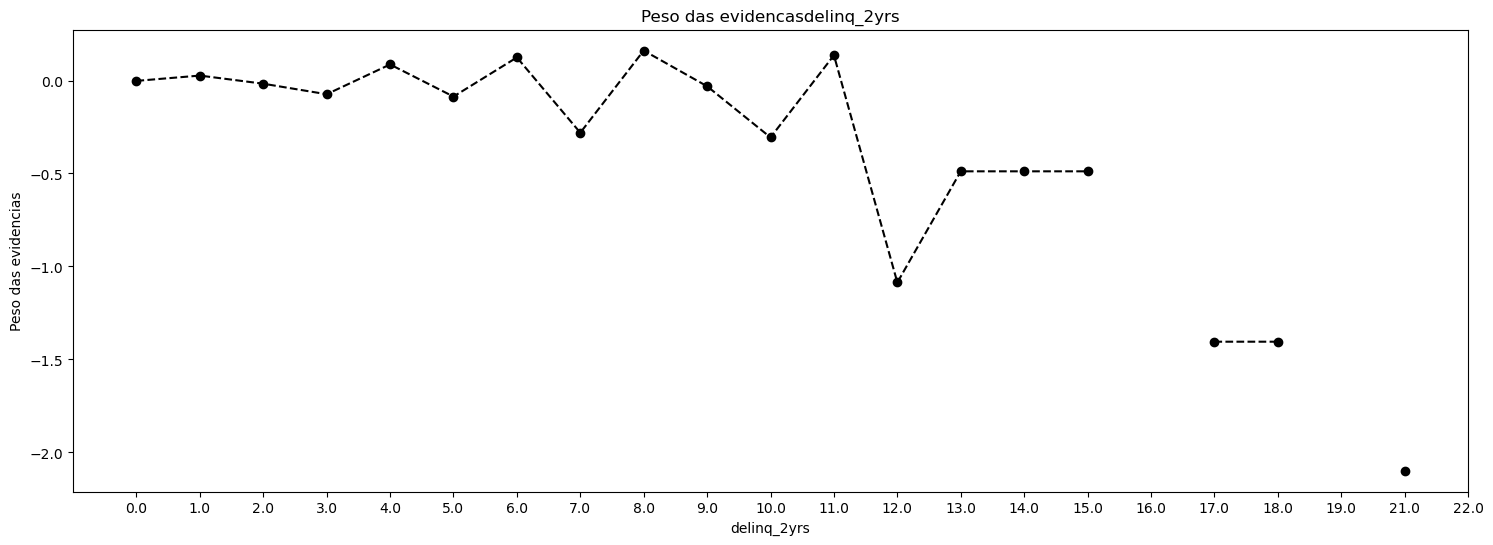

In [199]:
plot_woe(df_temp)
# We plot the weight of evidence values.

In [200]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

In [201]:
# inq_last_6mths
df_temp = wo_discretize_continuos(df_inputs_prepr, 'inq_last_6mths', df_target_prepr)
# We calculate weight of evidence.
df_temp

c:\Users\Graúna Motos\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,193232,0.908395,0.518009,175531.0,17701.0,0.528310,0.434082,0.196450,NaN,NaN,1.851103e-02,inf
1,1.0,104163,0.884950,0.279236,92179.0,11984.0,0.277439,0.293884,-0.057585,0.023446,0.254035,9.470026e-04,inf
2,2.0,46214,0.864197,0.123889,39938.0,6276.0,0.120205,0.153907,-0.247150,0.020753,0.189564,8.329398e-03,inf
3,3.0,20040,0.839671,0.053723,16827.0,3213.0,0.050646,0.078792,-0.441965,0.024526,0.194816,1.243995e-02,inf
4,4.0,5810,0.848365,0.015575,4929.0,881.0,0.014835,0.021605,-0.375911,0.008694,0.066054,2.544758e-03,inf
5,5.0,2217,0.824989,0.005943,1829.0,388.0,0.005505,0.009515,-0.547226,0.023376,0.171314,2.194399e-03,inf
6,6.0,977,0.788127,0.002619,770.0,207.0,0.002318,0.005076,-0.784073,0.036862,0.236848,2.163050e-03,inf
7,7.0,159,0.679245,0.000426,108.0,51.0,0.000325,0.001251,-1.347439,0.108882,0.563366,1.247214e-03,inf
8,8.0,101,0.643564,0.000271,65.0,36.0,0.000196,0.000883,-1.506877,0.035681,0.159437,1.035515e-03,inf
9,9.0,43,0.674419,0.000115,29.0,14.0,0.000087,0.000343,-1.369506,0.030854,0.137370,3.506467e-04,inf


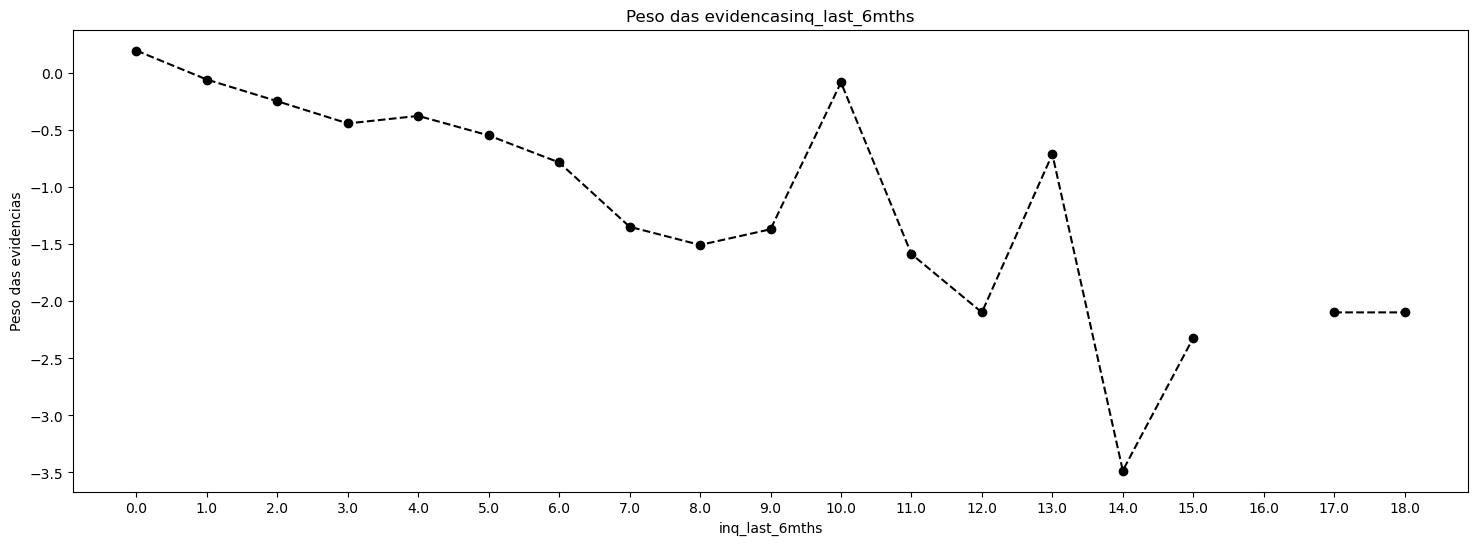

In [202]:
plot_woe(df_temp)
# We plot the weight of evidence values.

In [203]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [204]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'open_acc', df_target_prepr)
df_temp

c:\Users\Graúna Motos\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,29,0.758621,0.000078,22.0,7.0,0.000066,0.000172,-0.952613,NaN,NaN,0.000100,inf
1,1.0,110,0.872727,0.000295,96.0,14.0,0.000289,0.000343,-0.172454,0.114107,0.780159,0.000009,inf
2,2.0,1456,0.845467,0.003903,1231.0,225.0,0.003705,0.005518,-0.398263,0.027260,0.225809,0.000722,inf
3,3.0,4378,0.873687,0.011736,3825.0,553.0,0.011512,0.013561,-0.163789,0.028220,0.234474,0.000336,inf
4,4.0,10028,0.891504,0.026883,8940.0,1088.0,0.026907,0.026681,0.008449,0.017817,0.172239,0.000002,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,58.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf,inf
57,62.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf,inf
58,75.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf,inf
59,76.0,2,0.000000,0.000005,0.0,2.0,0.000000,0.000049,-inf,1.000000,inf,inf,inf


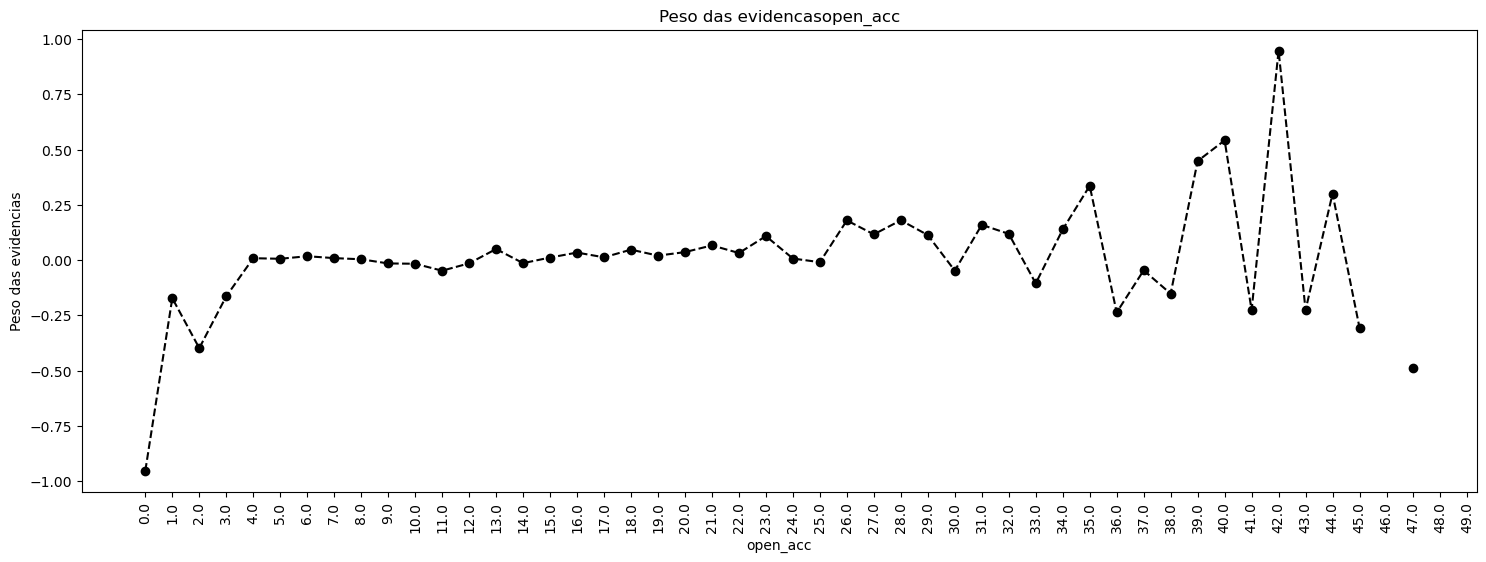

In [205]:
plot_woe(df_temp, 90)


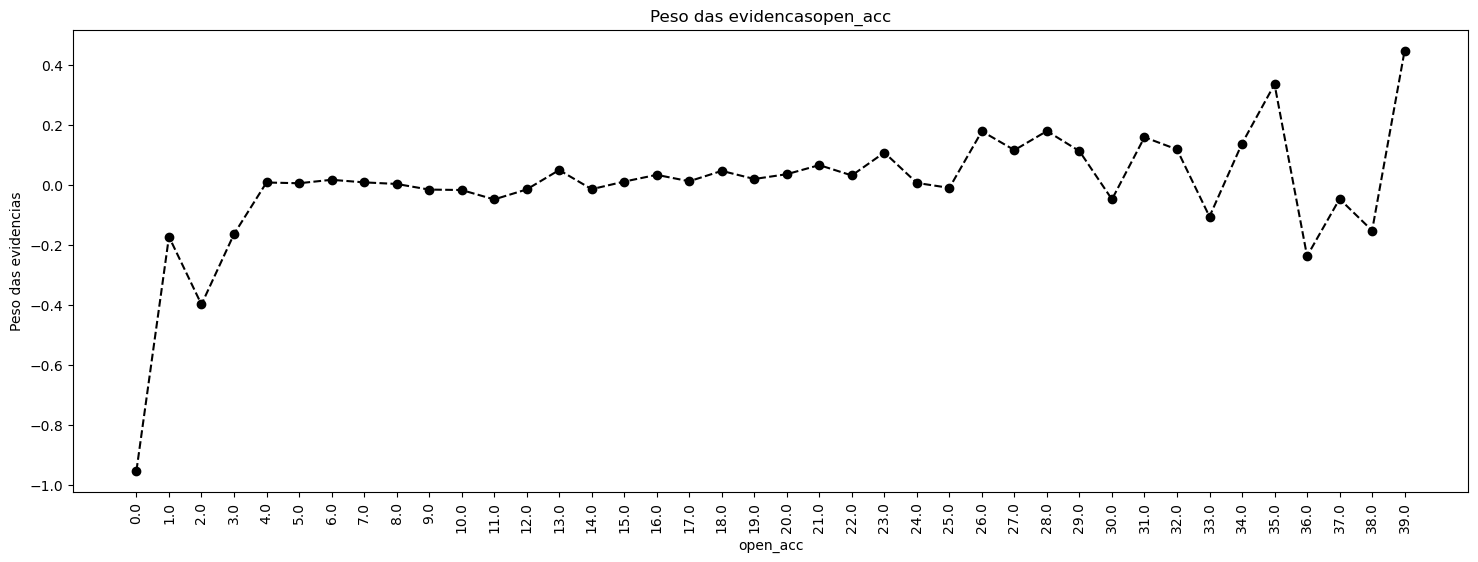

In [206]:
plot_woe(df_temp.iloc[ : 40, :], 90)


In [207]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [208]:
# pub_rec
df_temp = wo_discretize_continuos(df_inputs_prepr, 'pub_rec', df_target_prepr)
# We calculate weight of evidence.
df_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,323999,0.889941,0.868565,288340.0,35659.0,0.867840,0.874467,-0.007606,NaN,NaN,0.000050,inf
1,1.0,42381,0.893419,0.113613,37864.0,4517.0,0.113962,0.110771,0.028408,0.003478,0.036014,0.000091,inf
2,2.0,4527,0.903247,0.012136,4089.0,438.0,0.012307,0.010741,0.136092,0.009828,0.107684,0.000213,inf
3,3.0,1280,0.920312,0.003431,1178.0,102.0,0.003546,0.002501,0.348856,0.017065,0.212764,0.000364,inf
4,4.0,408,0.924020,0.001094,377.0,31.0,0.001135,0.000760,0.400513,0.003707,0.051657,0.000150,inf
5,5.0,203,0.911330,0.000544,185.0,18.0,0.000557,0.000441,0.232239,0.012690,0.168274,0.000027,inf
6,6.0,117,0.931624,0.000314,109.0,8.0,0.000328,0.000196,0.514161,0.020294,0.281922,0.000068,inf
7,7.0,48,0.958333,0.000129,46.0,2.0,0.000138,0.000049,1.037749,0.026709,0.523588,0.000093,inf
8,8.0,24,1.000000,0.000064,24.0,0.0,0.000072,0.000000,inf,0.041667,inf,inf,inf
9,9.0,14,0.785714,0.000038,11.0,3.0,0.000033,0.000074,-0.798462,0.214286,inf,0.000032,inf


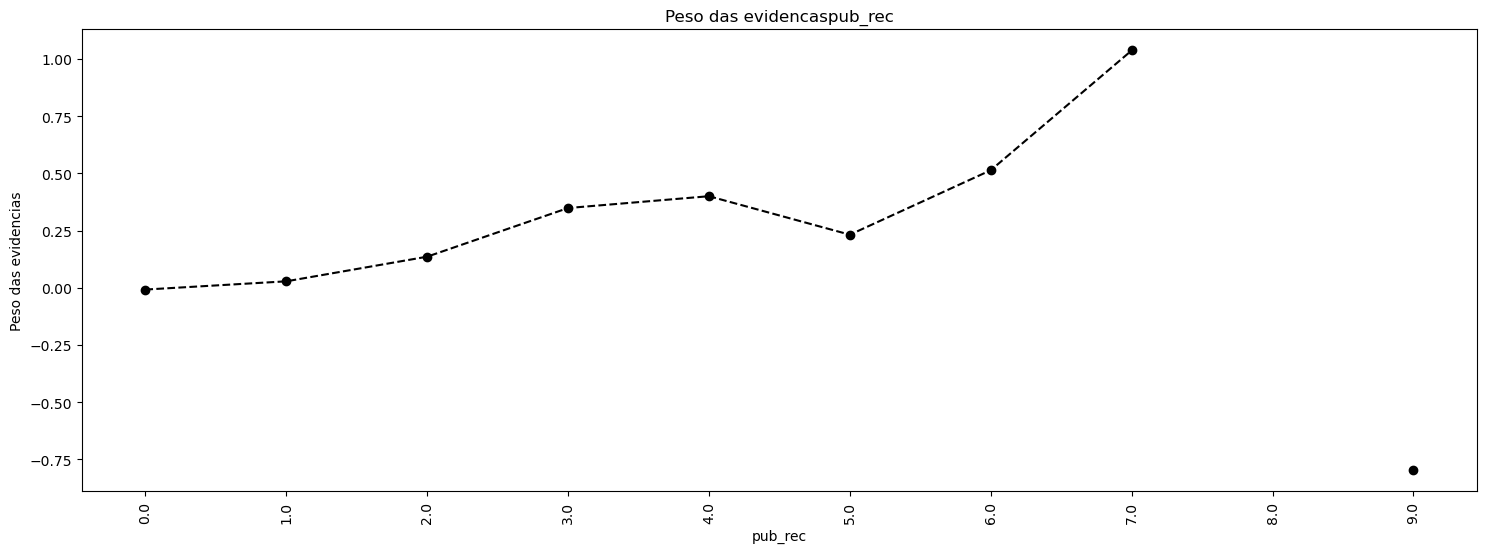

In [209]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [210]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [211]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'total_acc_factor', df_target_prepr)
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.15, 3.0]",459,0.810458,0.001230,372.0,87.0,0.001120,0.002134,-0.644759,NaN,NaN,6.536985e-04,inf
1,"(3.0, 6.0]",6004,0.864757,0.016095,5192.0,812.0,0.015627,0.019913,-0.242371,0.054299,0.402388,1.038781e-03,inf
2,"(6.0, 9.0]",15047,0.873131,0.040337,13138.0,1909.0,0.039543,0.046814,-0.168816,0.008374,0.073555,1.227619e-03,inf
3,"(9.0, 12.0]",25169,0.881283,0.067472,22181.0,2988.0,0.066760,0.073275,-0.093113,0.008152,0.075703,6.066170e-04,inf
4,"(12.0, 15.0]",33651,0.881281,0.090210,29656.0,3995.0,0.089258,0.097969,-0.093124,0.000001,0.000011,8.112416e-04,inf
5,"(15.0, 18.0]",38711,0.887267,0.103775,34347.0,4364.0,0.103377,0.107018,-0.034619,0.005986,0.058505,1.260669e-04,inf
6,"(18.0, 21.0]",40599,0.886155,0.108836,35977.0,4622.0,0.108283,0.113345,-0.045693,0.001112,0.011073,2.313196e-04,inf
7,"(21.0, 24.0]",40163,0.891492,0.107668,35805.0,4358.0,0.107765,0.106871,0.008329,0.005337,0.054022,7.445466e-06,inf
8,"(24.0, 27.0]",36286,0.895442,0.097274,32492.0,3794.0,0.097794,0.093040,0.049828,0.003950,0.041499,2.368559e-04,inf
9,"(27.0, 30.0]",31775,0.899103,0.085181,28569.0,3206.0,0.085986,0.078621,0.089553,0.003661,0.039725,6.596157e-04,inf


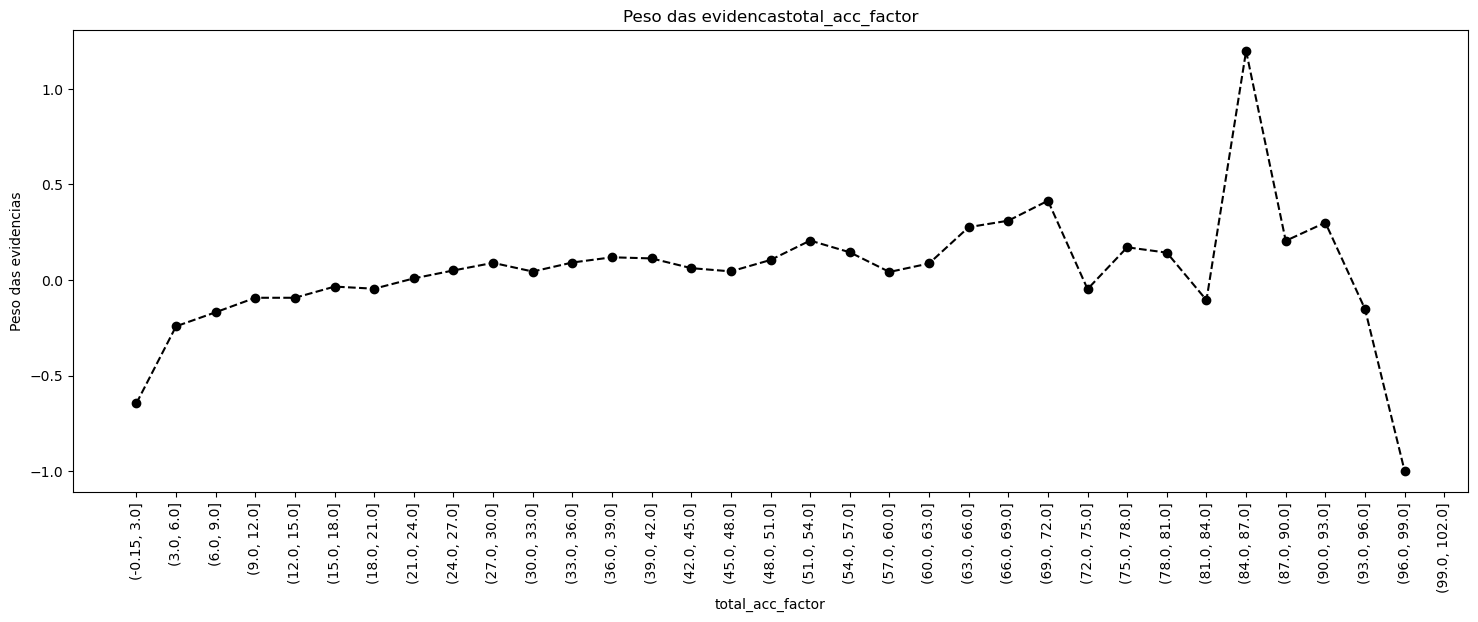

In [212]:
plot_woe(df_temp, 90)


In [213]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

In [214]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'acc_now_delinq', df_target_prepr)
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,371658,0.890649,0.996391,331017.0,40641.0,0.996352,0.996714,-0.000363,NaN,NaN,1.313247e-07,inf
1,1.0,1263,0.899446,0.003386,1136.0,127.0,0.003419,0.003115,0.093326,0.008796,0.093689,2.843412e-05,inf
2,2.0,70,0.928571,0.000188,65.0,5.0,0.000196,0.000123,0.467194,0.029126,0.373868,3.411639e-05,inf
3,3.0,7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.305996,0.071429,0.773190,1.978263e-06,inf
4,4.0,4,1.000000,0.000011,4.0,0.0,0.000012,0.000000,inf,0.142857,inf,inf,inf
5,5.0,2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.097755,0.500000,inf,4.513291e-05,inf


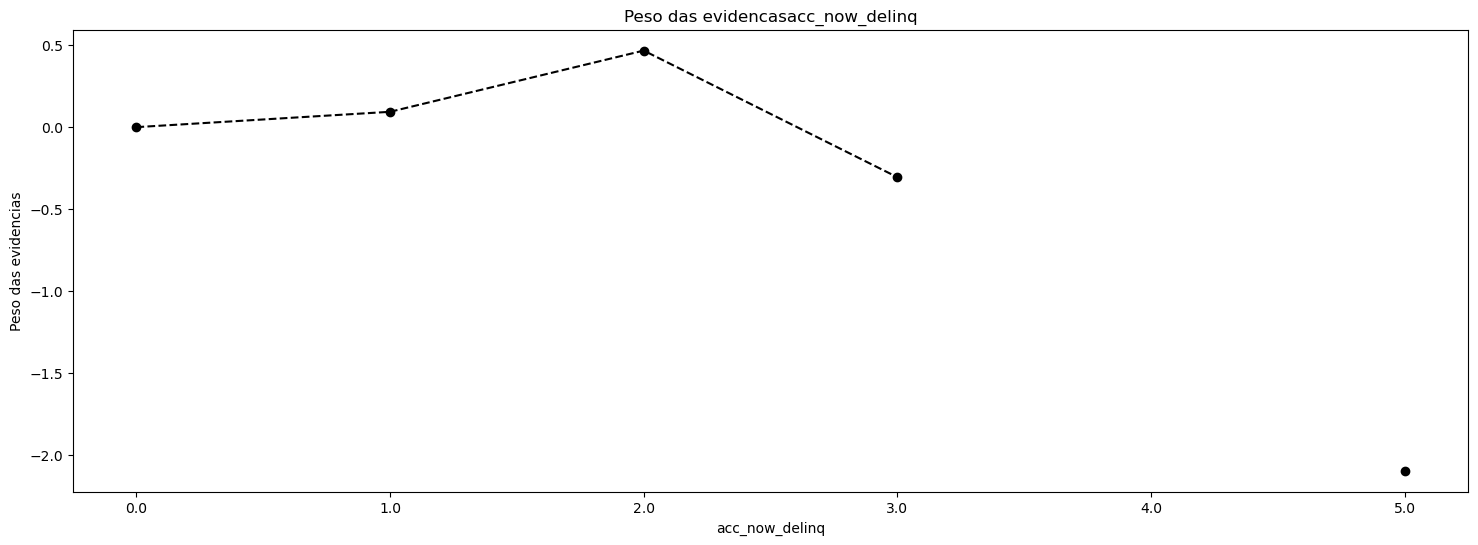

In [215]:
plot_woe(df_temp)


In [216]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [217]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'total_rev_hi_lim_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()
c:\Users\Graúna Motos\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-9999.999, 5000.0]",10011,0.878334,0.031608,8793.0,1218.0,0.030885,0.038038,-0.208309,NaN,NaN,0.001490,inf
1,"(5000.0, 9999.999]",36042,0.884440,0.113796,31877.0,4165.0,0.111966,0.130071,-0.149886,0.006107,0.058423,0.002714,inf
2,"(9999.999, 14999.998]",46249,0.886765,0.146023,41012.0,5237.0,0.144052,0.163549,-0.126939,0.002325,0.022947,0.002475,inf
3,"(14999.998, 19999.998]",43941,0.887986,0.138736,39019.0,4922.0,0.137052,0.153712,-0.114721,0.001221,0.012218,0.001911,inf
4,"(19999.998, 24999.997]",36634,0.894524,0.115665,32770.0,3864.0,0.115102,0.120671,-0.047244,0.006538,0.067477,0.000263,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


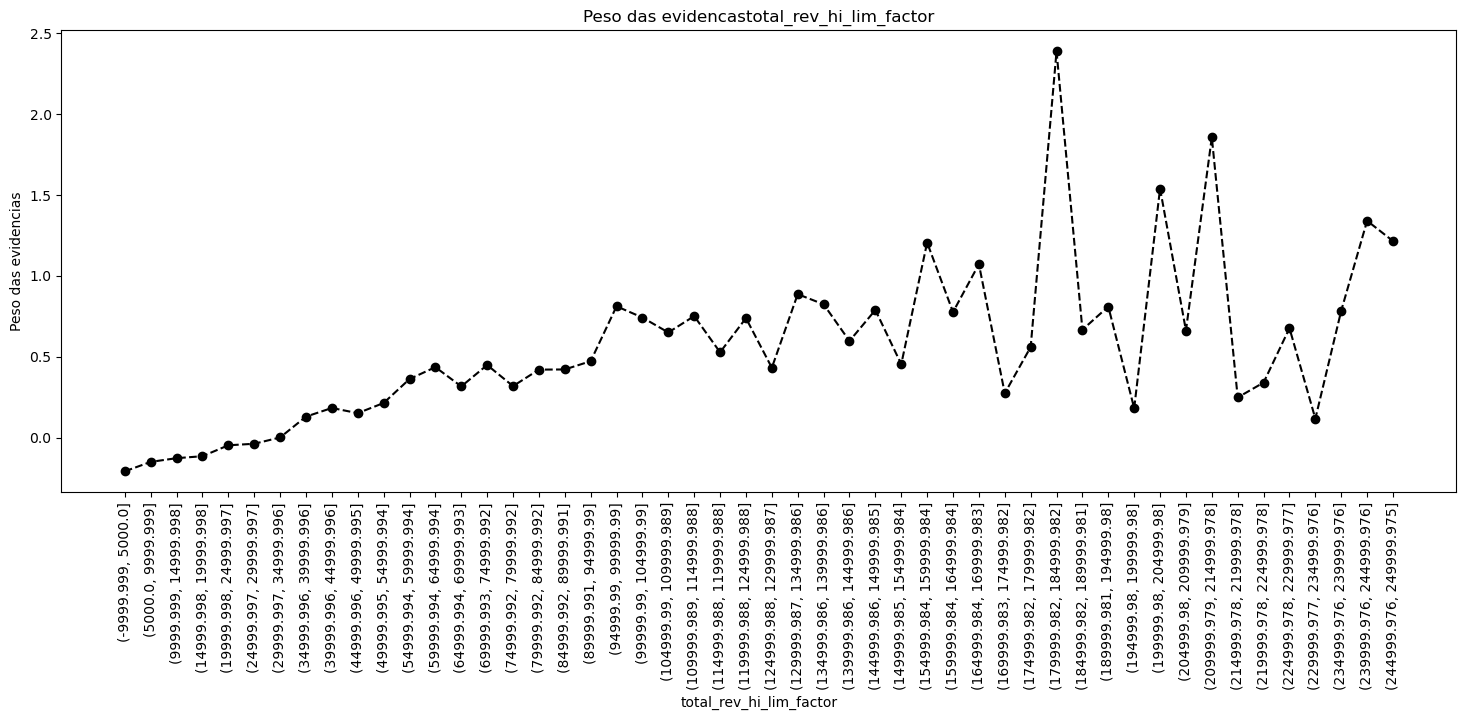

In [218]:
plot_woe(df_temp.iloc[: 50, : ], 90)
# We plot the weight of evidence values.

In [219]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

In [220]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'installment_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(14.276, 43.556]",1812,0.906181,0.004858,1642.0,170.0,0.004942,0.004169,0.170127,NaN,NaN,1.315331e-04,0.013497
1,"(43.556, 71.443]",4841,0.897542,0.012978,4345.0,496.0,0.013078,0.012163,0.072460,0.008639,0.097667,6.623439e-05,0.013497
2,"(71.443, 99.329]",6824,0.893025,0.018294,6094.0,730.0,0.018342,0.017902,0.024270,0.004517,0.048190,1.067415e-05,0.013497
3,"(99.329, 127.216]",9138,0.890348,0.024497,8136.0,1002.0,0.024488,0.024572,-0.003444,0.002677,0.027715,2.910056e-07,0.013497
4,"(127.216, 155.102]",10040,0.896514,0.026915,9001.0,1039.0,0.027091,0.025479,0.061332,0.006166,0.064776,9.884391e-05,0.013497
5,"(155.102, 182.988]",16816,0.894208,0.045080,15037.0,1779.0,0.045258,0.043626,0.036717,0.002306,0.024615,5.990905e-05,0.013497
6,"(182.988, 210.875]",17216,0.904798,0.046152,15577.0,1639.0,0.046883,0.040193,0.153964,0.010590,0.117247,1.030040e-03,0.013497
7,"(210.875, 238.761]",15090,0.900398,0.040453,13587.0,1503.0,0.040894,0.036858,0.103905,0.004400,0.050059,4.193408e-04,0.013497
8,"(238.761, 266.648]",18842,0.901391,0.050511,16984.0,1858.0,0.051118,0.045564,0.115026,0.000993,0.011121,6.388952e-04,0.013497
9,"(266.648, 294.534]",20100,0.891095,0.053883,17911.0,2189.0,0.053908,0.053681,0.004225,0.010296,0.110801,9.603802e-07,0.013497


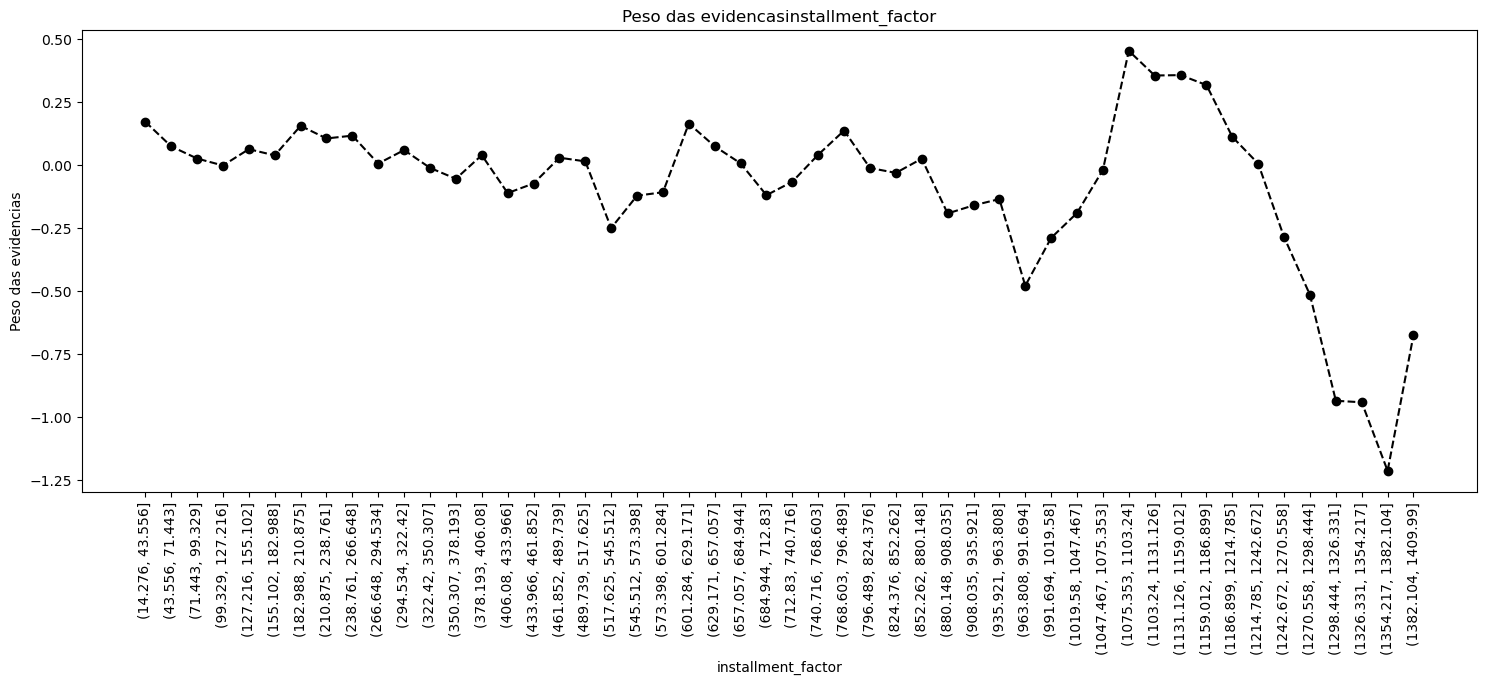

In [221]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [222]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'annual_inc_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-5243.882, 144693.64]",351904,0.888566,0.943372,312690.0,39214.0,0.941129,0.961646,-0.021567,NaN,NaN,4.424871e-04,inf
1,"(144693.64, 287491.28]",19004,0.925437,0.050945,17587.0,1417.0,0.052933,0.034749,0.420873,0.036871,0.442440,7.653115e-03,inf
2,"(287491.28, 430288.92]",1525,0.930492,0.004088,1419.0,106.0,0.004271,0.002599,0.496524,0.005055,0.075651,8.299092e-04,inf
3,"(430288.92, 573086.56]",332,0.939759,0.000890,312.0,20.0,0.000939,0.000490,0.649526,0.009267,0.153002,2.913717e-04,inf
4,"(573086.56, 715884.2]",112,0.883929,0.000300,99.0,13.0,0.000298,0.000319,-0.067574,0.055830,0.717100,1.407641e-06,inf
5,"(715884.2, 858681.84]",65,0.892308,0.000174,58.0,7.0,0.000175,0.000172,0.016788,0.008379,0.084362,4.878818e-08,inf
6,"(858681.84, 1001479.48]",39,0.974359,0.000105,38.0,1.0,0.000114,0.000025,1.539841,0.082051,1.523053,1.383527e-04,inf
7,"(1001479.48, 1144277.12]",10,1.000000,0.000027,10.0,0.0,0.000030,0.000000,inf,0.025641,inf,inf,inf
8,"(1144277.12, 1287074.76]",12,1.000000,0.000032,12.0,0.0,0.000036,0.000000,inf,0.000000,NaN,inf,inf
9,"(1287074.76, 1429872.4]",6,1.000000,0.000016,6.0,0.0,0.000018,0.000000,inf,0.000000,NaN,inf,inf


In [223]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'annual_inc_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-5243.882, 73294.82]",231445,0.875901,0.620449,202723.0,28722.0,0.610152,0.704350,-0.143568,NaN,NaN,0.013524,inf
1,"(73294.82, 144693.64]",120459,0.912900,0.322922,109967.0,10492.0,0.330977,0.257296,0.251822,0.036998,0.395390,0.018555,inf
2,"(144693.64, 216092.46]",15885,0.925087,0.042584,14695.0,1190.0,0.044229,0.029182,0.415809,0.012187,0.163987,0.006256,inf
3,"(216092.46, 287491.28]",3119,0.927220,0.008361,2892.0,227.0,0.008704,0.005567,0.447009,0.002134,0.031200,0.001403,inf
4,"(287491.28, 358890.1]",1117,0.929275,0.002994,1038.0,79.0,0.003124,0.001937,0.477858,0.002055,0.030850,0.000567,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(6784783.9, 6856182.72]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(6856182.72, 6927581.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(6927581.54, 6998980.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(6998980.36, 7070379.18]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [224]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

In [225]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'annual_inc_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\4067983087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True 

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(1757.896, 4658.08]",15,0.800000,0.000043,12.0,3.0,0.000038,0.000077,-0.689458,NaN,NaN,0.000026,0.049818
1,"(4658.08, 7420.16]",40,0.750000,0.000114,30.0,10.0,0.000096,0.000256,-0.977140,0.050000,0.287682,0.000156,0.049818
2,"(7420.16, 10182.24]",287,0.874564,0.000818,251.0,36.0,0.000805,0.000920,-0.133818,0.124564,0.843322,0.000015,0.049818
3,"(10182.24, 12944.32]",547,0.828154,0.001558,453.0,94.0,0.001452,0.002402,-0.503155,0.046411,0.369337,0.000478,0.049818
4,"(12944.32, 15706.4]",1210,0.830579,0.003447,1005.0,205.0,0.003222,0.005238,-0.486019,0.002425,0.017135,0.000980,0.049818
5,"(15706.4, 18468.48]",1522,0.847569,0.004335,1290.0,232.0,0.004136,0.005928,-0.360092,0.016990,0.125927,0.000646,0.049818
6,"(18468.48, 21230.56]",2928,0.855533,0.008340,2505.0,423.0,0.008031,0.010809,-0.297080,0.007964,0.063012,0.000825,0.049818
7,"(21230.56, 23992.64]",2495,0.844489,0.007107,2107.0,388.0,0.006755,0.009914,-0.383737,0.011044,0.086657,0.001212,0.049818
8,"(23992.64, 26754.72]",7016,0.848632,0.019985,5954.0,1062.0,0.019088,0.027137,-0.351843,0.004143,0.031894,0.002832,0.049818
9,"(26754.72, 29516.8]",5643,0.857345,0.016074,4838.0,805.0,0.015510,0.020570,-0.282338,0.008714,0.069505,0.001429,0.049818


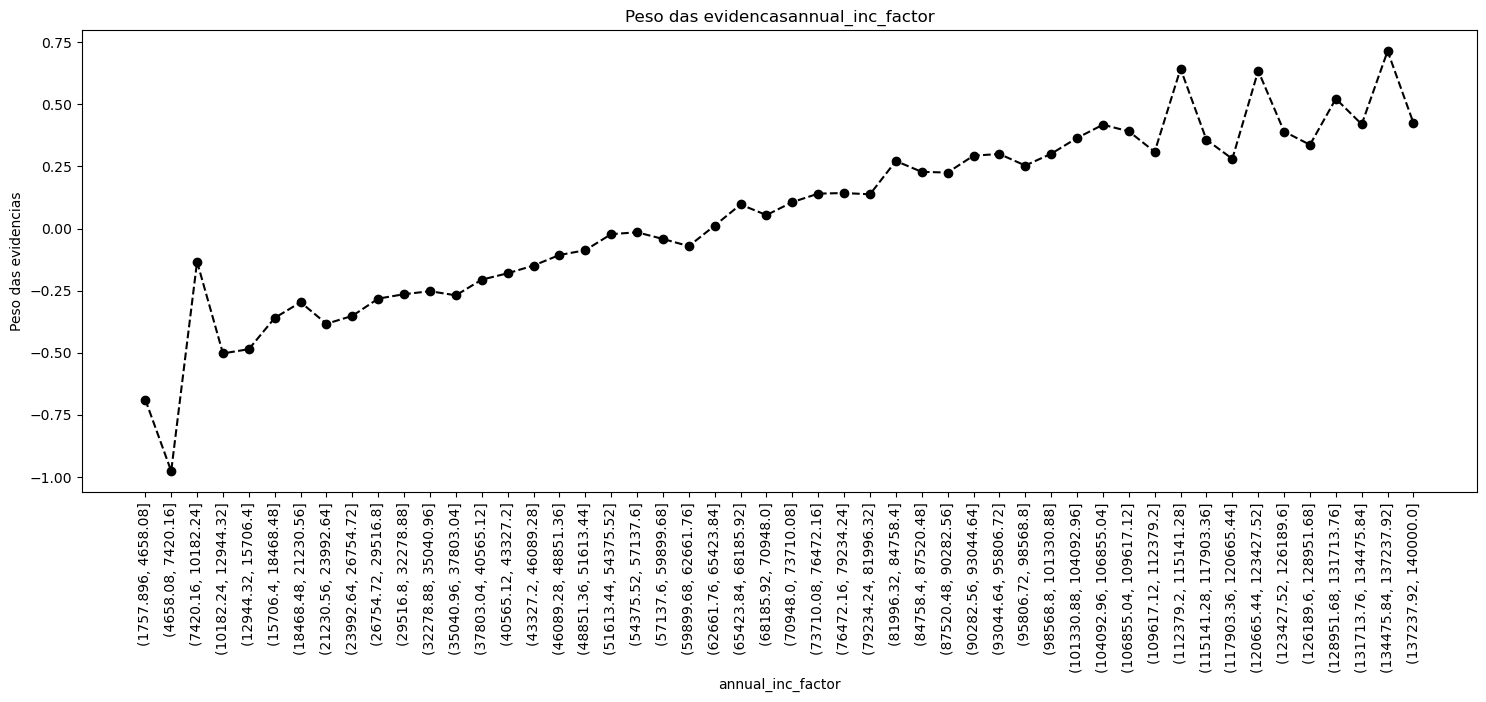

In [226]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [227]:
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [228]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\2833956029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and 

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.188, 3.76]",5277,0.871518,0.030531,4599.0,678.0,0.029814,0.036481,-0.201825,NaN,NaN,1.345636e-03,inf
1,"(3.76, 7.52]",11167,0.887615,0.064608,9912.0,1255.0,0.064256,0.067528,-0.049661,0.016097,0.152164,1.624709e-04,inf
2,"(7.52, 11.28]",13306,0.892830,0.076983,11880.0,1426.0,0.077014,0.076729,0.003711,0.005215,0.053372,1.058786e-06,inf
3,"(11.28, 15.04]",13216,0.888847,0.076462,11747.0,1469.0,0.076152,0.079042,-0.037256,0.003983,0.040967,1.076913e-04,inf
4,"(15.04, 18.8]",9337,0.894934,0.054020,8356.0,981.0,0.054169,0.052785,0.025891,0.006087,0.063147,3.584565e-05,inf
5,"(18.8, 22.56]",11641,0.892707,0.067350,10392.0,1249.0,0.067368,0.067205,0.002421,0.002227,0.023470,3.944869e-07,inf
6,"(22.56, 26.32]",10887,0.896298,0.062988,9758.0,1129.0,0.063258,0.060748,0.040483,0.003592,0.038062,1.016031e-04,inf
7,"(26.32, 30.08]",10560,0.895076,0.061096,9452.0,1108.0,0.061274,0.059618,0.027398,0.001223,0.013085,4.537112e-05,inf
8,"(30.08, 33.84]",7576,0.902191,0.043832,6835.0,741.0,0.044309,0.039871,0.105539,0.007115,0.078141,4.683861e-04,inf
9,"(33.84, 37.6]",9795,0.897397,0.056670,8790.0,1005.0,0.056982,0.054076,0.052355,0.004794,0.053184,1.521758e-04,inf


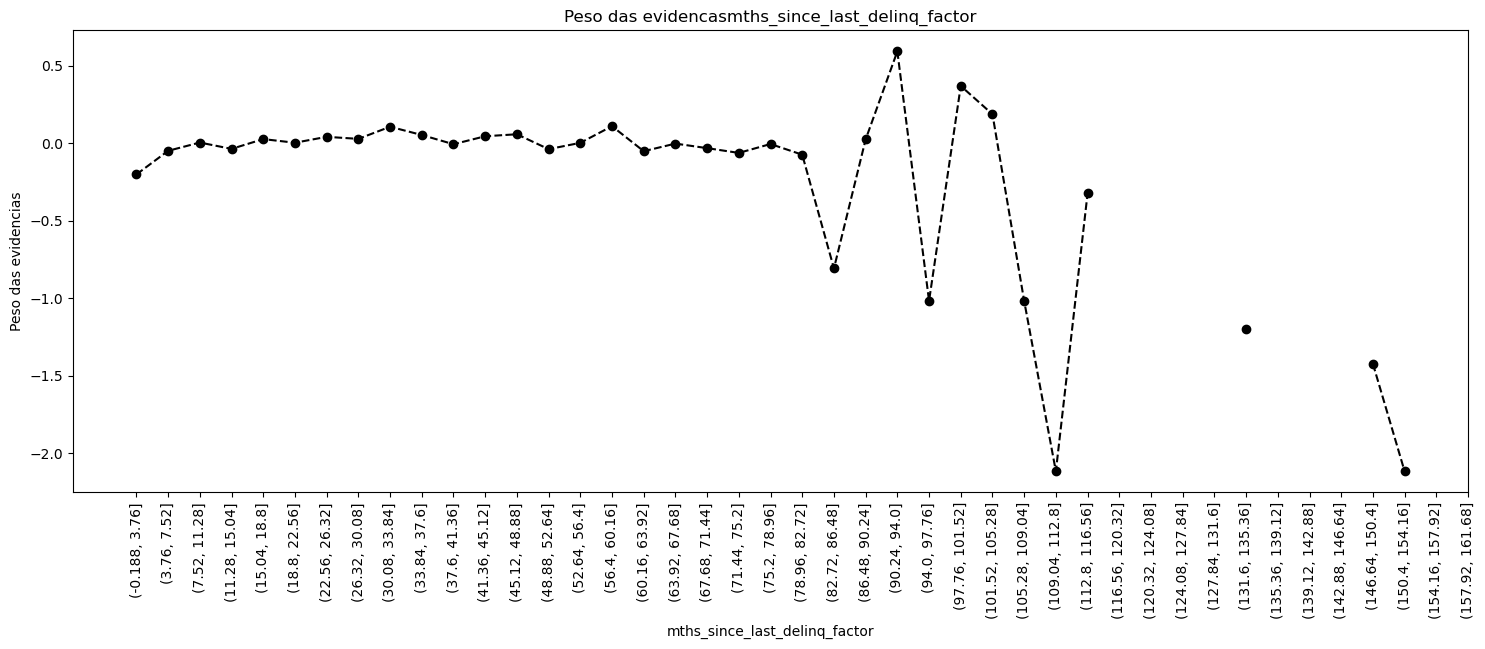

In [229]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [230]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

In [231]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'dti_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.04, 0.4]",745,0.876510,0.001997,653.0,92.0,0.001965,0.002256,-0.137956,NaN,NaN,4.010821e-05,0.028446
1,"(0.4, 0.8]",808,0.919554,0.002166,743.0,65.0,0.002236,0.001594,0.338564,0.043044,0.476520,2.174497e-04,0.028446
2,"(0.8, 1.2]",922,0.896963,0.002472,827.0,95.0,0.002489,0.002330,0.066183,0.022591,0.272381,1.054967e-05,0.028446
3,"(1.2, 1.6]",1043,0.896453,0.002796,935.0,108.0,0.002814,0.002648,0.060670,0.000511,0.005513,1.005059e-05,0.028446
4,"(1.6, 2.0]",1172,0.902730,0.003142,1058.0,114.0,0.003184,0.002796,0.130192,0.006278,0.069522,5.060883e-05,0.028446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",202,0.856436,0.000542,173.0,29.0,0.000521,0.000711,-0.311749,0.060231,0.611900,5.938060e-05,0.028446
96,"(38.39, 38.79]",193,0.880829,0.000517,170.0,23.0,0.000512,0.000564,-0.097441,0.024393,0.214308,5.102653e-06,0.028446
97,"(38.79, 39.19]",192,0.869792,0.000515,167.0,25.0,0.000503,0.000613,-0.198627,0.011037,0.101186,2.193679e-05,0.028446
98,"(39.19, 39.59]",183,0.918033,0.000491,168.0,15.0,0.000506,0.000368,0.318169,0.048241,0.516796,4.384300e-05,0.028446


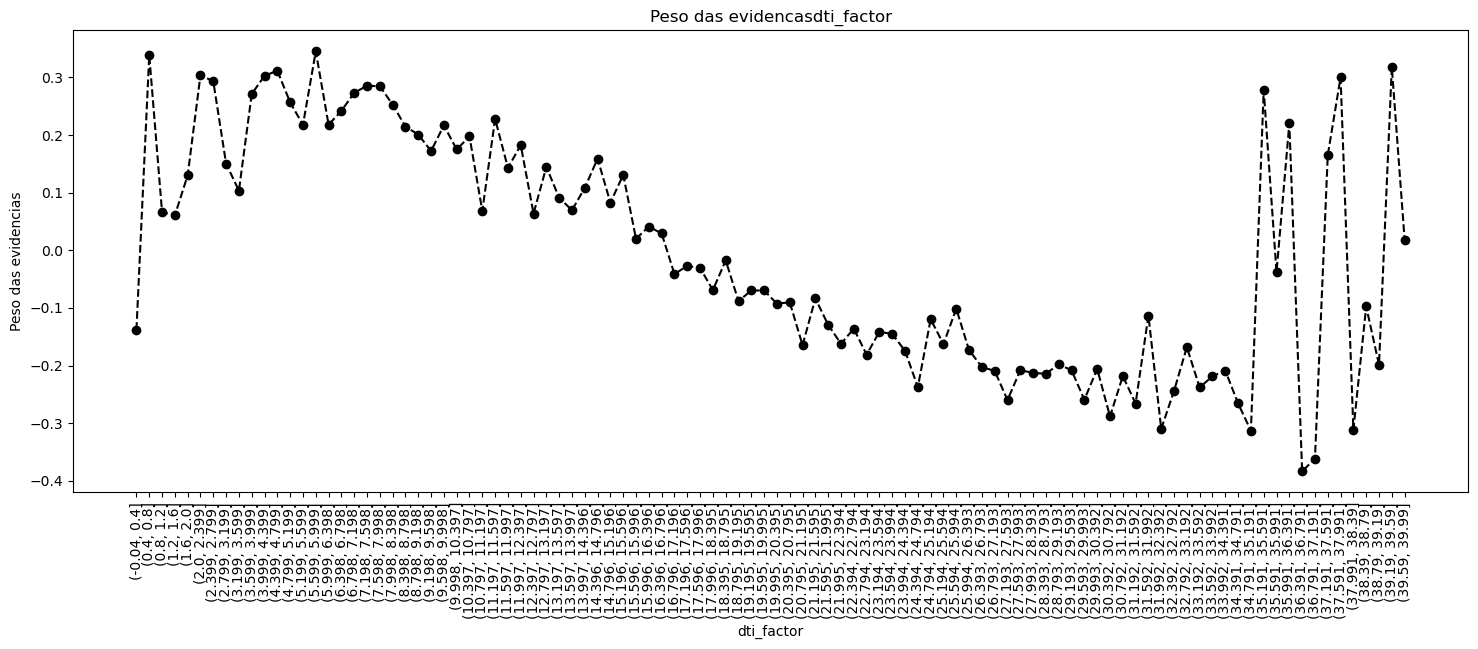

In [232]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [233]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [234]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'dti_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\873747522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
C:\Users\Graúna Motos\Documents\credit_risk\src\utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.035, 0.7]",1366,0.894583,0.003690,1222.0,144.0,0.003707,0.003560,0.040465,NaN,NaN,5.948000e-06,0.027289
1,"(0.7, 1.4]",1664,0.893029,0.004496,1486.0,178.0,0.004507,0.004400,0.024094,0.001554,0.016371,2.585298e-06,0.027289
2,"(1.4, 2.1]",1986,0.912890,0.005365,1813.0,173.0,0.005499,0.004276,0.251481,0.019861,0.227387,3.074939e-04,0.027289
3,"(2.1, 2.8]",2594,0.913261,0.007008,2369.0,225.0,0.007186,0.005562,0.256157,0.000371,0.004676,4.159432e-04,0.027289
4,"(2.8, 3.5]",3135,0.903030,0.008470,2831.0,304.0,0.008587,0.007515,0.133392,0.010231,0.122765,1.430370e-04,0.027289
5,"(3.5, 4.2]",3844,0.915713,0.010385,3520.0,324.0,0.010677,0.008009,0.287507,0.012682,0.154115,7.670015e-04,0.027289
6,"(4.2, 4.9]",4595,0.914037,0.012414,4200.0,395.0,0.012739,0.009764,0.265988,0.001676,0.021519,7.913863e-04,0.027289
7,"(4.9, 5.6]",5312,0.912651,0.014351,4848.0,464.0,0.014705,0.011470,0.248471,0.001386,0.017517,8.038406e-04,0.027289
8,"(5.6, 6.3]",5927,0.914797,0.016013,5422.0,505.0,0.016446,0.012483,0.275696,0.002146,0.027225,1.092500e-03,0.027289
9,"(6.3, 7.0]",6482,0.911601,0.017512,5909.0,573.0,0.017923,0.014164,0.235381,0.003195,0.040315,8.847855e-04,0.027289


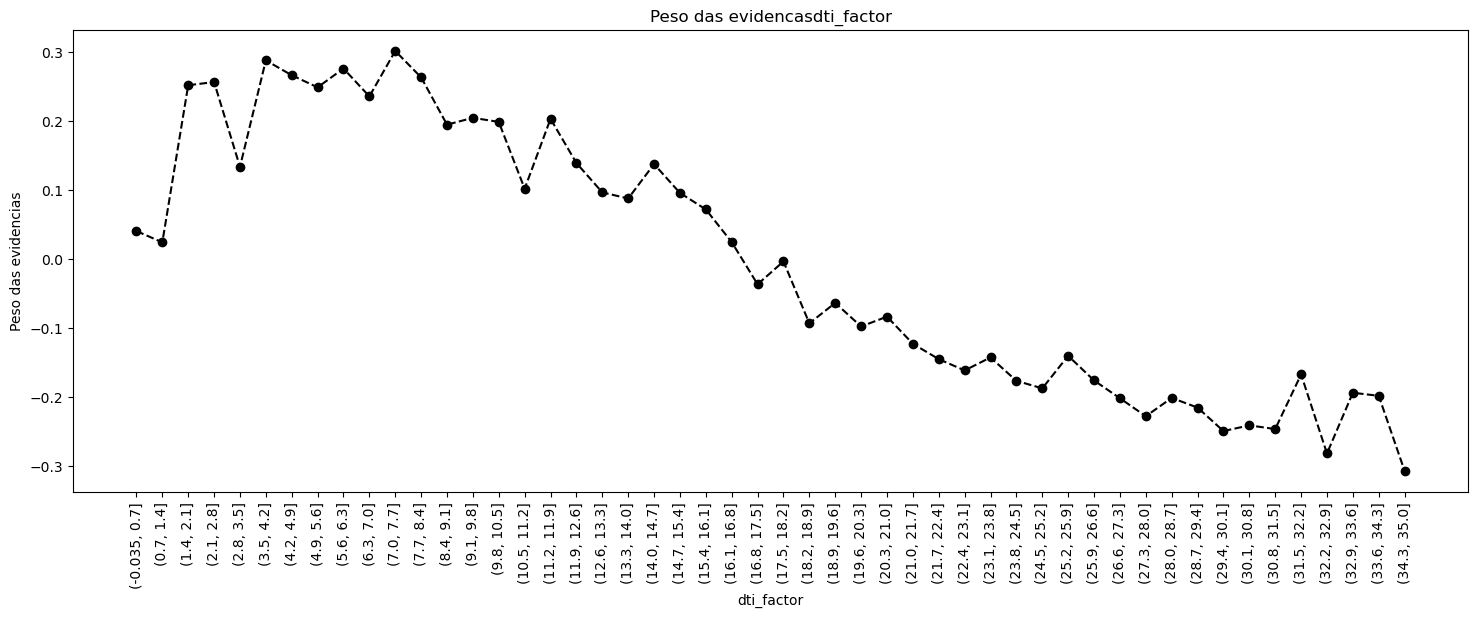

In [235]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [236]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\284476014.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\284476014.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\284

In [237]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\4294264355.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\4294264355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
C:\Users\Graúna Motos\Documents\credit_risk\src\utils

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.121, 2.42]",1086,0.764273,0.021691,830.0,256.0,0.018569,0.047672,-0.942830,NaN,NaN,2.743898e-02,0.080659
1,"(2.42, 4.84]",76,0.894737,0.001518,68.0,8.0,0.001521,0.001490,0.020988,0.130464,0.963818,6.631477e-07,0.080659
2,"(4.84, 7.26]",163,0.914110,0.003256,149.0,14.0,0.003334,0.002607,0.245810,0.019374,0.224823,1.785766e-04,0.080659
3,"(7.26, 9.68]",156,0.903846,0.003116,141.0,15.0,0.003155,0.002793,0.121631,0.010264,0.124179,4.394269e-05,0.080659
4,"(9.68, 12.1]",292,0.907534,0.005832,265.0,27.0,0.005929,0.005028,0.164814,0.003688,0.043183,1.484775e-04,0.080659
5,"(12.1, 14.52]",207,0.917874,0.004134,190.0,17.0,0.004251,0.003166,0.294732,0.010340,0.129918,3.198166e-04,0.080659
6,"(14.52, 16.94]",210,0.928571,0.004194,195.0,15.0,0.004363,0.002793,0.445871,0.010697,0.151139,6.997555e-04,0.080659
7,"(16.94, 19.36]",334,0.907186,0.006671,303.0,31.0,0.006779,0.005773,0.160667,0.021386,0.285204,1.616579e-04,0.080659
8,"(19.36, 21.78]",283,0.936396,0.005652,265.0,18.0,0.005929,0.003352,0.570280,0.029210,0.409612,1.469527e-03,0.080659
9,"(21.78, 24.2]",455,0.898901,0.009088,409.0,46.0,0.009151,0.008566,0.065995,0.037495,0.504284,3.856726e-05,0.080659


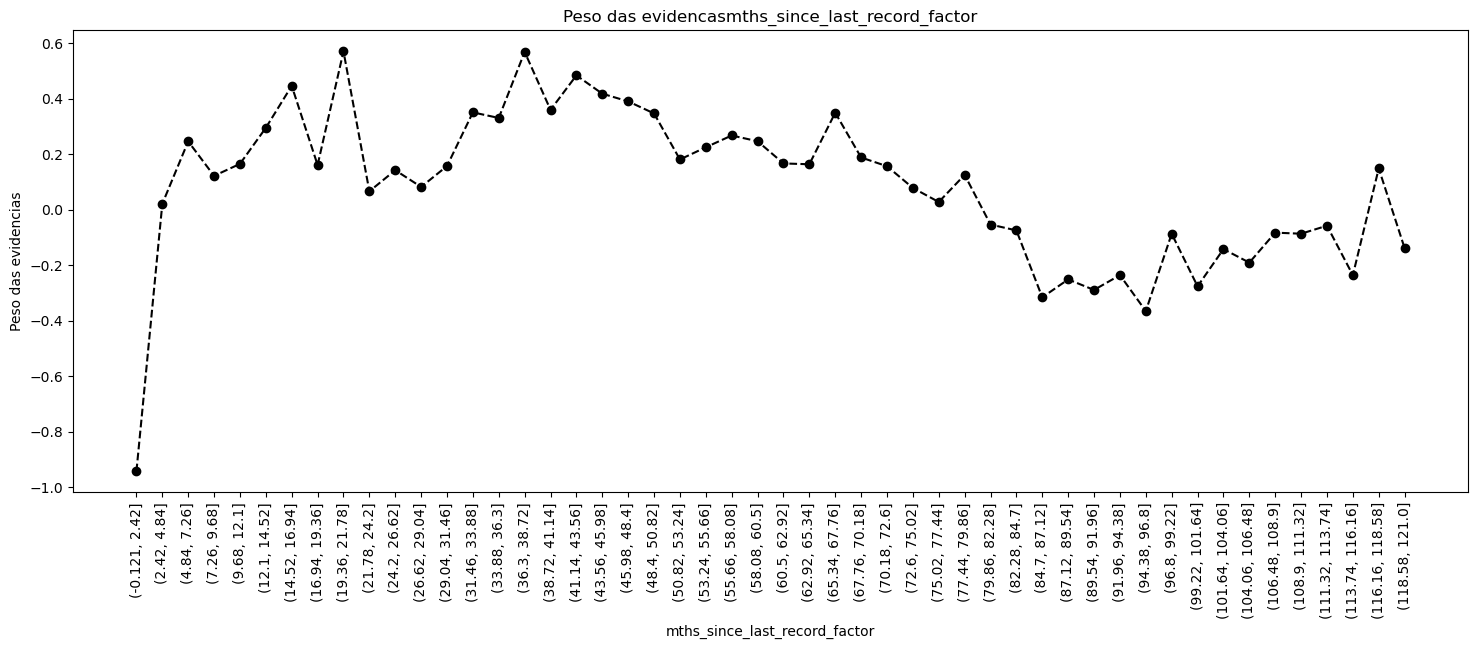

In [238]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [239]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\1059239224.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
C:\Users\Graúna Motos\AppData\Local\Temp\ipykernel_33516\1059239224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
C:\Users\

In [240]:
#####
#loan_data_inputs_train = df_inputs_prepr
#####
#loan_data_inputs_test = df_inputs_prepr

In [241]:
'''loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
loan_data_targets_train.to_csv('loan_data_targets_train.csv')
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
loan_data_targets_test.to_csv('loan_data_targets_test.csv')'''

"loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')\nloan_data_targets_train.to_csv('loan_data_targets_train.csv')\nloan_data_inputs_test.to_csv('loan_data_inputs_test.csv')\nloan_data_targets_test.to_csv('loan_data_targets_test.csv')"